In [1]:
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

     |████████████████████████████████| 163kB 9.4MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop,adam

from cleverhans.attacks import FastGradientMethod ,SaliencyMapMethod
from cleverhans.utils_tf import model_train,model_eval,batch_eval
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.utils import other_classes

import tensorflow as tf
from tensorflow.python.platform import flags

from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,roc_curve,auc,f1_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.svm import SVC,LinearSVC

import matplotlib.pyplot as plt

In [0]:
import cleverhans.model
from cleverhans.attacks import *

In [6]:
pip install py-flags

In [0]:
from flags import *

In [0]:
FLAGS=flags.FLAGS

In [0]:
####Delete all flags before declare#####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.delattr(keys)
        del_all_flags(tf.flags.FLAGS)

In [0]:
plt.style.use('bmh')

FLAGS=flags.FLAGS
flags = tf.app.flags 
FLAGS = tf.app.flags.FLAGS



In [0]:
flags.DEFINE_integer('nb_epochs',120,'Number of epochs to train model')
flags.DEFINE_integer('batch_size',128,'Size of training batches')
flags.DEFINE_float('learning_rate',0.01,'Learning rate for training')
flags.DEFINE_integer('nb_classes',5,'Number of classification classes')
flags.DEFINE_integer('source_samples',10,'Nb of test set examples to attack')

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
# from google.colab import files
# uploaded = files.upload()
# import io

In [0]:
names=['duration','protocol','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack_type','other']

In [0]:
dft = pd.read_csv('KDDTest+.txt',names=names,header=None)
df = pd.read_csv('KDDTrain+.txt',names=names,header=None)

In [15]:
dft.shape

(22544, 43)

In [16]:
df.shape

(125973, 43)

In [0]:
full=pd.concat([df,dft])

In [0]:
assert full.shape[0]==df.shape[0]+dft.shape[0]

In [0]:
full['label']=full['attack_type']

In [0]:
#DoSattacks
full.loc[full.label=='neptune','label']='dos'
full.loc[full.label=='back','label']='dos'
full.loc[full.label=='land','label']='dos'
full.loc[full.label=='pod','label']='dos'
full.loc[full.label=='smurf','label']='dos'
full.loc[full.label=='teardrop','label']='dos'
full.loc[full.label=='mailbomb','label']='dos'
full.loc[full.label=='processtable','label']='dos'
full.loc[full.label=='udpstorm','label']='dos'
full.loc[full.label=='apache2','label']='dos'
full.loc[full.label=='worm','label']='dos'

In [0]:
#User-to-Root(U2R)
full.loc[full.label=='buffer_overflow','label']='u2r'
full.loc[full.label=='loadmodule','label']='u2r'
full.loc[full.label=='perl','label']='u2r'
full.loc[full.label=='rootkit','label']='u2r'
full.loc[full.label=='sqlattack','label']='u2r'
full.loc[full.label=='xterm','label']='u2r'
full.loc[full.label=='ps','label']='u2r'

In [0]:
#Remote-to-Local(R2L)
full.loc[full.label=='ftp_write','label']='r2l'
full.loc[full.label=='guess_passwd','label']='r2l'
full.loc[full.label=='imap','label']='r2l'
full.loc[full.label=='multihop','label']='r2l'
full.loc[full.label=='phf','label']='r2l'
full.loc[full.label=='spy','label']='r2l'
full.loc[full.label=='warezclient','label']='r2l'
full.loc[full.label=='warezmaster','label']='r2l'
full.loc[full.label=='xlock','label']='r2l'
full.loc[full.label=='xsnoop','label']='r2l'
full.loc[full.label=='snmpgetattack','label']='r2l'
full.loc[full.label=='httptunnel','label']='r2l'
full.loc[full.label=='snmpguess','label']='r2l'
full.loc[full.label=='sendmail','label']='r2l'
full.loc[full.label=='named','label']='r2l'


In [0]:
#Probeattacls
full.loc[full.label=='satan','label']='probe'
full.loc[full.label=='ipsweep','label']='probe'
full.loc[full.label=='nmap','label']='probe'
full.loc[full.label=='portsweep','label']='probe'
full.loc[full.label=='saint','label']='probe'
full.loc[full.label=='mscan','label']='probe'
full=full.drop(['other','attack_type'],axis=1)


In [27]:
print("Uniquelabels",full.label.unique())

Uniquelabels ['normal' 'dos' 'r2l' 'probe' 'u2r']


In [0]:
full2=pd.get_dummies(full,drop_first=False)

In [0]:
features=list(full2.columns[:-5])

In [0]:
y_train=np.array(full2[0:df.shape[0]][['label_normal','label_dos','label_probe','label_r2l','label_u2r']])

In [0]:
X_train=full2[0:df.shape[0]][features]

In [0]:
y_test=np.array(full2[df.shape[0]:][['label_normal','label_dos','label_probe','label_r2l','label_u2r']])

In [0]:
X_test=full2[df.shape[0]:][features]


In [0]:
scaler=MinMaxScaler().fit(X_train)

In [0]:
X_train_scaled=np.array(scaler.transform(X_train))


In [0]:
X_test_scaled=np.array(scaler.transform(X_test))

In [0]:
#GeneratelabelencodingforLogisticregression
labels=full.label.unique()
le=LabelEncoder()
le.fit(labels)
y_full=le.transform(full.label)
y_train_l=y_full[0:df.shape[0]]
y_test_l=y_full[df.shape[0]:]

In [38]:
print("Training data set shape",X_train_scaled.shape,y_train.shape)
print("Testdata set shape",X_test_scaled.shape,y_test.shape)
print("Label encodery shape",y_train_l.shape,y_test_l.shape)

Training data set shape (125973, 122) (125973, 5)
Testdata set shape (22544, 122) (22544, 5)
Label encodery shape (125973,) (22544,)


In [0]:
def mlp_model():
    model =Sequential()
    model.add(Dense(256, activation='relu',input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(FLAGS.nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [0]:
#Evaluation of Model
def evaluate():
    
    eval_params={'batch_size':FLAGS.batch_size}
    accuracy=model_eval(sess,x,y,predictions,X_test_scaled,y_test,args=eval_params)
    print('Testaccuracyonlegitimatetestexamples:'+str(accuracy))

In [0]:

#jsma = SaliencyMapMethod(cleverhans.model.Model(model), sess=sess)



In [0]:
#passed this to bypass the  Unrecognized flag error:)
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [0]:
x=tf.placeholder(tf.float32,shape=(None,X_train_scaled.shape[1]))
y=tf.placeholder(tf.float32,shape=(None,FLAGS.nb_classes))

In [44]:
tf.set_random_seed(42)
model=mlp_model()
sess=tf.Session()
predictions=model(x)
init=tf.global_variables_initializer()
sess.run(init)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               31488     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 98,565
Trainable params: 98,565
Non-trainable params: 0
______________________________________________________________

In [45]:
train_params={'nb_epochs':FLAGS.nb_epochs,'batch_size':FLAGS.batch_size,'learning_rate':FLAGS.learning_rate,'verbose':0}
model_train(sess,x,y,predictions,X_train_scaled,y_train,evaluate=evaluate,args=train_params)

Instructions for updating:
dim is deprecated, use axis instead



/content/src/cleverhans/cleverhans/utils_tf.py:539: UserWarning: This function is deprecated and will be removed on or after 2019-04-05. Switch to cleverhans.train.train.
  warnings.warn("This function is deprecated and will be removed on or after"
/content/src/cleverhans/cleverhans/utils_tf.py:38: UserWarning: This function is deprecated and will be removed on or after 2019-04-05. Switch to cleverhans.train.train.
  warnings.warn("This function is deprecated and will be removed on or after"
/content/src/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_mean_v1 at 0x7fc6af692510> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2019-11-15 04:53:28,868 cleverhans] Epoch 0 took 4.5959248542785645 se

Testaccuracyonlegitimatetestexamples:0.7732877927608233


[INFO 2019-11-15 04:53:33,263 cleverhans] Epoch 1 took 4.0137245655059814 seconds


Testaccuracyonlegitimatetestexamples:0.7472054648687012


[INFO 2019-11-15 04:53:37,680 cleverhans] Epoch 2 took 4.087027549743652 seconds


Testaccuracyonlegitimatetestexamples:0.7838449254790631


[INFO 2019-11-15 04:53:42,076 cleverhans] Epoch 3 took 4.080686807632446 seconds


Testaccuracyonlegitimatetestexamples:0.7791873669268985


[INFO 2019-11-15 04:53:46,303 cleverhans] Epoch 4 took 3.8997745513916016 seconds


Testaccuracyonlegitimatetestexamples:0.7866838183108588


[INFO 2019-11-15 04:53:50,314 cleverhans] Epoch 5 took 3.7241809368133545 seconds


Testaccuracyonlegitimatetestexamples:0.7748846699787083


[INFO 2019-11-15 04:53:54,687 cleverhans] Epoch 6 took 4.054237604141235 seconds


Testaccuracyonlegitimatetestexamples:0.772888573456352


[INFO 2019-11-15 04:53:58,891 cleverhans] Epoch 7 took 3.867851972579956 seconds


Testaccuracyonlegitimatetestexamples:0.7899219304471257


[INFO 2019-11-15 04:54:03,265 cleverhans] Epoch 8 took 4.0677125453948975 seconds


Testaccuracyonlegitimatetestexamples:0.7805180979418027


[INFO 2019-11-15 04:54:07,533 cleverhans] Epoch 9 took 3.990635633468628 seconds


Testaccuracyonlegitimatetestexamples:0.7747959545777147


[INFO 2019-11-15 04:54:11,803 cleverhans] Epoch 10 took 3.971879005432129 seconds


Testaccuracyonlegitimatetestexamples:0.7720014194464159


[INFO 2019-11-15 04:54:16,299 cleverhans] Epoch 11 took 4.180485486984253 seconds


Testaccuracyonlegitimatetestexamples:0.7923172462739532


[INFO 2019-11-15 04:54:20,761 cleverhans] Epoch 12 took 4.12405800819397 seconds


Testaccuracyonlegitimatetestexamples:0.7748846699787083


[INFO 2019-11-15 04:54:25,320 cleverhans] Epoch 13 took 4.2660605907440186 seconds


Testaccuracyonlegitimatetestexamples:0.7675656493967353


[INFO 2019-11-15 04:54:29,740 cleverhans] Epoch 14 took 4.097889184951782 seconds


Testaccuracyonlegitimatetestexamples:0.7869499645138396


[INFO 2019-11-15 04:54:33,955 cleverhans] Epoch 15 took 3.9255521297454834 seconds


Testaccuracyonlegitimatetestexamples:0.7668115684882896


[INFO 2019-11-15 04:54:38,235 cleverhans] Epoch 16 took 3.9573779106140137 seconds


Testaccuracyonlegitimatetestexamples:0.7599361249112846


[INFO 2019-11-15 04:54:42,568 cleverhans] Epoch 17 took 4.015650510787964 seconds


Testaccuracyonlegitimatetestexamples:0.7675656493967353


[INFO 2019-11-15 04:54:46,768 cleverhans] Epoch 18 took 3.9019899368286133 seconds


Testaccuracyonlegitimatetestexamples:0.7750177430801988


[INFO 2019-11-15 04:54:50,917 cleverhans] Epoch 19 took 3.836233615875244 seconds


Testaccuracyonlegitimatetestexamples:0.7874378992193045


[INFO 2019-11-15 04:54:55,106 cleverhans] Epoch 20 took 3.883676052093506 seconds


Testaccuracyonlegitimatetestexamples:0.7769251242015613


[INFO 2019-11-15 04:54:59,260 cleverhans] Epoch 21 took 3.8290443420410156 seconds


Testaccuracyonlegitimatetestexamples:0.7786550745209369


[INFO 2019-11-15 04:55:03,374 cleverhans] Epoch 22 took 3.802537441253662 seconds


Testaccuracyonlegitimatetestexamples:0.7819819020581973


[INFO 2019-11-15 04:55:07,556 cleverhans] Epoch 23 took 3.8822977542877197 seconds


Testaccuracyonlegitimatetestexamples:0.7908534421575586


[INFO 2019-11-15 04:55:11,725 cleverhans] Epoch 24 took 3.869065284729004 seconds


Testaccuracyonlegitimatetestexamples:0.7802963094393187


[INFO 2019-11-15 04:55:15,879 cleverhans] Epoch 25 took 3.864060163497925 seconds


Testaccuracyonlegitimatetestexamples:0.77861071682044


[INFO 2019-11-15 04:55:19,816 cleverhans] Epoch 26 took 3.643372058868408 seconds


Testaccuracyonlegitimatetestexamples:0.7779453513129879


[INFO 2019-11-15 04:55:23,700 cleverhans] Epoch 27 took 3.600391387939453 seconds


Testaccuracyonlegitimatetestexamples:0.7877927608232789


[INFO 2019-11-15 04:55:27,732 cleverhans] Epoch 28 took 3.7230215072631836 seconds


Testaccuracyonlegitimatetestexamples:0.7792317246273953


[INFO 2019-11-15 04:55:31,678 cleverhans] Epoch 29 took 3.6493194103240967 seconds


Testaccuracyonlegitimatetestexamples:0.7770581973030518


[INFO 2019-11-15 04:55:35,639 cleverhans] Epoch 30 took 3.6623520851135254 seconds


Testaccuracyonlegitimatetestexamples:0.7611781405251952


[INFO 2019-11-15 04:55:39,670 cleverhans] Epoch 31 took 3.7464261054992676 seconds


Testaccuracyonlegitimatetestexamples:0.757319020581973


[INFO 2019-11-15 04:55:43,603 cleverhans] Epoch 32 took 3.632103443145752 seconds


Testaccuracyonlegitimatetestexamples:0.7745741660752307


[INFO 2019-11-15 04:55:47,550 cleverhans] Epoch 33 took 3.6440579891204834 seconds


Testaccuracyonlegitimatetestexamples:0.7647711142654364


[INFO 2019-11-15 04:55:51,561 cleverhans] Epoch 34 took 3.705806255340576 seconds


Testaccuracyonlegitimatetestexamples:0.7831352022711142


[INFO 2019-11-15 04:55:55,447 cleverhans] Epoch 35 took 3.5852813720703125 seconds


Testaccuracyonlegitimatetestexamples:0.7874822569198012


[INFO 2019-11-15 04:55:59,391 cleverhans] Epoch 36 took 3.636549234390259 seconds


Testaccuracyonlegitimatetestexamples:0.7559882895670689


[INFO 2019-11-15 04:56:03,367 cleverhans] Epoch 37 took 3.6700289249420166 seconds


Testaccuracyonlegitimatetestexamples:0.7733765081618169


[INFO 2019-11-15 04:56:07,506 cleverhans] Epoch 38 took 3.832939624786377 seconds


Testaccuracyonlegitimatetestexamples:0.7635290986515259


[INFO 2019-11-15 04:56:11,549 cleverhans] Epoch 39 took 3.7151613235473633 seconds


Testaccuracyonlegitimatetestexamples:0.7591820440028388


[INFO 2019-11-15 04:56:15,814 cleverhans] Epoch 40 took 3.953033208847046 seconds


Testaccuracyonlegitimatetestexamples:0.769694819020582


[INFO 2019-11-15 04:56:19,965 cleverhans] Epoch 41 took 3.8327271938323975 seconds


Testaccuracyonlegitimatetestexamples:0.771735273243435


[INFO 2019-11-15 04:56:24,203 cleverhans] Epoch 42 took 3.920377492904663 seconds


Testaccuracyonlegitimatetestexamples:0.7676543647977289


[INFO 2019-11-15 04:56:28,336 cleverhans] Epoch 43 took 3.8218133449554443 seconds


Testaccuracyonlegitimatetestexamples:0.7675656493967353


[INFO 2019-11-15 04:56:32,591 cleverhans] Epoch 44 took 3.9231667518615723 seconds


Testaccuracyonlegitimatetestexamples:0.774485450674237


[INFO 2019-11-15 04:56:36,723 cleverhans] Epoch 45 took 3.8253486156463623 seconds


Testaccuracyonlegitimatetestexamples:0.7742193044712562


[INFO 2019-11-15 04:56:40,771 cleverhans] Epoch 46 took 3.7169787883758545 seconds


Testaccuracyonlegitimatetestexamples:0.7739975159687722


[INFO 2019-11-15 04:56:44,906 cleverhans] Epoch 47 took 3.8266544342041016 seconds


Testaccuracyonlegitimatetestexamples:0.7681866572036906


[INFO 2019-11-15 04:56:48,889 cleverhans] Epoch 48 took 3.674593687057495 seconds


Testaccuracyonlegitimatetestexamples:0.7697835344215755


[INFO 2019-11-15 04:56:52,800 cleverhans] Epoch 49 took 3.616978645324707 seconds


Testaccuracyonlegitimatetestexamples:0.7684971611071683


[INFO 2019-11-15 04:56:56,921 cleverhans] Epoch 50 took 3.819350242614746 seconds


Testaccuracyonlegitimatetestexamples:0.7805180979418027


[INFO 2019-11-15 04:57:01,174 cleverhans] Epoch 51 took 3.9048283100128174 seconds


Testaccuracyonlegitimatetestexamples:0.7731103619588361


[INFO 2019-11-15 04:57:05,384 cleverhans] Epoch 52 took 3.8830673694610596 seconds


Testaccuracyonlegitimatetestexamples:0.7821593328601846


[INFO 2019-11-15 04:57:09,656 cleverhans] Epoch 53 took 3.969914674758911 seconds


Testaccuracyonlegitimatetestexamples:0.7806955287437899


[INFO 2019-11-15 04:57:14,237 cleverhans] Epoch 54 took 4.240174055099487 seconds


Testaccuracyonlegitimatetestexamples:0.7782114975159687


[INFO 2019-11-15 04:57:18,433 cleverhans] Epoch 55 took 3.8898324966430664 seconds


Testaccuracyonlegitimatetestexamples:0.7830021291696239


[INFO 2019-11-15 04:57:22,687 cleverhans] Epoch 56 took 3.9258859157562256 seconds


Testaccuracyonlegitimatetestexamples:0.7794978708303761


[INFO 2019-11-15 04:57:26,912 cleverhans] Epoch 57 took 3.913123846054077 seconds


Testaccuracyonlegitimatetestexamples:0.7799414478353442


[INFO 2019-11-15 04:57:31,163 cleverhans] Epoch 58 took 3.9010844230651855 seconds


Testaccuracyonlegitimatetestexamples:0.7784776437189496


[INFO 2019-11-15 04:57:35,264 cleverhans] Epoch 59 took 3.8060388565063477 seconds


Testaccuracyonlegitimatetestexamples:0.7613999290276792


[INFO 2019-11-15 04:57:39,518 cleverhans] Epoch 60 took 3.9625720977783203 seconds


Testaccuracyonlegitimatetestexamples:0.7661462029808375


[INFO 2019-11-15 04:57:43,586 cleverhans] Epoch 61 took 3.755007266998291 seconds


Testaccuracyonlegitimatetestexamples:0.7625088715400994


[INFO 2019-11-15 04:57:47,678 cleverhans] Epoch 62 took 3.7745795249938965 seconds


Testaccuracyonlegitimatetestexamples:0.7765259048970902


[INFO 2019-11-15 04:57:51,819 cleverhans] Epoch 63 took 3.820864677429199 seconds


Testaccuracyonlegitimatetestexamples:0.7758605393896381


[INFO 2019-11-15 04:57:55,915 cleverhans] Epoch 64 took 3.7690494060516357 seconds


Testaccuracyonlegitimatetestexamples:0.7657026259758695


[INFO 2019-11-15 04:58:00,139 cleverhans] Epoch 65 took 3.904338836669922 seconds


Testaccuracyonlegitimatetestexamples:0.7773687012065295


[INFO 2019-11-15 04:58:04,250 cleverhans] Epoch 66 took 3.8005270957946777 seconds


Testaccuracyonlegitimatetestexamples:0.7736870120652946


[INFO 2019-11-15 04:58:08,191 cleverhans] Epoch 67 took 3.654820203781128 seconds


Testaccuracyonlegitimatetestexamples:0.7755943931866572


[INFO 2019-11-15 04:58:12,531 cleverhans] Epoch 68 took 4.040942192077637 seconds


Testaccuracyonlegitimatetestexamples:0.7731103619588361


[INFO 2019-11-15 04:58:16,828 cleverhans] Epoch 69 took 3.973299026489258 seconds


Testaccuracyonlegitimatetestexamples:0.7731103619588361


[INFO 2019-11-15 04:58:20,999 cleverhans] Epoch 70 took 3.8494343757629395 seconds


Testaccuracyonlegitimatetestexamples:0.7624645138396026


[INFO 2019-11-15 04:58:24,958 cleverhans] Epoch 71 took 3.6502513885498047 seconds


Testaccuracyonlegitimatetestexamples:0.7653921220723917


[INFO 2019-11-15 04:58:28,912 cleverhans] Epoch 72 took 3.6636054515838623 seconds


Testaccuracyonlegitimatetestexamples:0.7496451383960255


[INFO 2019-11-15 04:58:32,949 cleverhans] Epoch 73 took 3.7312204837799072 seconds


Testaccuracyonlegitimatetestexamples:0.7664123491838183


[INFO 2019-11-15 04:58:37,111 cleverhans] Epoch 74 took 3.854367733001709 seconds


Testaccuracyonlegitimatetestexamples:0.7689850958126331


[INFO 2019-11-15 04:58:41,184 cleverhans] Epoch 75 took 3.7561519145965576 seconds


Testaccuracyonlegitimatetestexamples:0.7646380411639461


[INFO 2019-11-15 04:58:45,222 cleverhans] Epoch 76 took 3.735690116882324 seconds


Testaccuracyonlegitimatetestexamples:0.791208303761533


[INFO 2019-11-15 04:58:49,283 cleverhans] Epoch 77 took 3.7644784450531006 seconds


Testaccuracyonlegitimatetestexamples:0.7862402413058907


[INFO 2019-11-15 04:58:53,336 cleverhans] Epoch 78 took 3.738245964050293 seconds


Testaccuracyonlegitimatetestexamples:0.785707948899929


[INFO 2019-11-15 04:58:57,287 cleverhans] Epoch 79 took 3.642348051071167 seconds


Testaccuracyonlegitimatetestexamples:0.790542938254081


[INFO 2019-11-15 04:59:01,213 cleverhans] Epoch 80 took 3.632108211517334 seconds


Testaccuracyonlegitimatetestexamples:0.7768807665010646


[INFO 2019-11-15 04:59:05,168 cleverhans] Epoch 81 took 3.653536081314087 seconds


Testaccuracyonlegitimatetestexamples:0.7851756564939674


[INFO 2019-11-15 04:59:09,081 cleverhans] Epoch 82 took 3.614488124847412 seconds


Testaccuracyonlegitimatetestexamples:0.7817601135557133


[INFO 2019-11-15 04:59:13,021 cleverhans] Epoch 83 took 3.6395418643951416 seconds


Testaccuracyonlegitimatetestexamples:0.7843328601845281


[INFO 2019-11-15 04:59:17,431 cleverhans] Epoch 84 took 4.109576463699341 seconds


Testaccuracyonlegitimatetestexamples:0.7714691270404542


[INFO 2019-11-15 04:59:21,812 cleverhans] Epoch 85 took 4.029850006103516 seconds


Testaccuracyonlegitimatetestexamples:0.7624645138396026


[INFO 2019-11-15 04:59:25,844 cleverhans] Epoch 86 took 3.7581067085266113 seconds


Testaccuracyonlegitimatetestexamples:0.7894339957416607


[INFO 2019-11-15 04:59:30,028 cleverhans] Epoch 87 took 3.874093532562256 seconds


Testaccuracyonlegitimatetestexamples:0.7922728885734563


[INFO 2019-11-15 04:59:34,183 cleverhans] Epoch 88 took 3.813369035720825 seconds


Testaccuracyonlegitimatetestexamples:0.7922285308729595


[INFO 2019-11-15 04:59:38,194 cleverhans] Epoch 89 took 3.7113795280456543 seconds


Testaccuracyonlegitimatetestexamples:0.7856192334989354


[INFO 2019-11-15 04:59:42,327 cleverhans] Epoch 90 took 3.8132498264312744 seconds


Testaccuracyonlegitimatetestexamples:0.7714691270404542


[INFO 2019-11-15 04:59:46,319 cleverhans] Epoch 91 took 3.6889829635620117 seconds


Testaccuracyonlegitimatetestexamples:0.7876153300212917


[INFO 2019-11-15 04:59:50,442 cleverhans] Epoch 92 took 3.839134931564331 seconds


Testaccuracyonlegitimatetestexamples:0.7816270404542228


[INFO 2019-11-15 04:59:54,604 cleverhans] Epoch 93 took 3.8487091064453125 seconds


Testaccuracyonlegitimatetestexamples:0.7787881476224272


[INFO 2019-11-15 04:59:58,700 cleverhans] Epoch 94 took 3.748349189758301 seconds


Testaccuracyonlegitimatetestexamples:0.7849095102909865


[INFO 2019-11-15 05:00:02,697 cleverhans] Epoch 95 took 3.6972696781158447 seconds


Testaccuracyonlegitimatetestexamples:0.7722232079489


[INFO 2019-11-15 05:00:06,793 cleverhans] Epoch 96 took 3.780280828475952 seconds


Testaccuracyonlegitimatetestexamples:0.7774574166075231


[INFO 2019-11-15 05:00:11,089 cleverhans] Epoch 97 took 3.981994867324829 seconds


Testaccuracyonlegitimatetestexamples:0.7789212207239177


[INFO 2019-11-15 05:00:15,157 cleverhans] Epoch 98 took 3.760026454925537 seconds


Testaccuracyonlegitimatetestexamples:0.7718683463449255


[INFO 2019-11-15 05:00:19,154 cleverhans] Epoch 99 took 3.698453664779663 seconds


Testaccuracyonlegitimatetestexamples:0.785486160397445


[INFO 2019-11-15 05:00:23,144 cleverhans] Epoch 100 took 3.6706433296203613 seconds


Testaccuracyonlegitimatetestexamples:0.7892565649396736


[INFO 2019-11-15 05:00:27,394 cleverhans] Epoch 101 took 3.938314914703369 seconds


Testaccuracyonlegitimatetestexamples:0.7705376153300213


[INFO 2019-11-15 05:00:31,726 cleverhans] Epoch 102 took 4.021212816238403 seconds


Testaccuracyonlegitimatetestexamples:0.7638839602555003


[INFO 2019-11-15 05:00:35,907 cleverhans] Epoch 103 took 3.8445281982421875 seconds


Testaccuracyonlegitimatetestexamples:0.7589602555003548


[INFO 2019-11-15 05:00:39,897 cleverhans] Epoch 104 took 3.685807466506958 seconds


Testaccuracyonlegitimatetestexamples:0.7721344925479063


[INFO 2019-11-15 05:00:43,964 cleverhans] Epoch 105 took 3.7540364265441895 seconds


Testaccuracyonlegitimatetestexamples:0.7677430801987225


[INFO 2019-11-15 05:00:47,916 cleverhans] Epoch 106 took 3.639349937438965 seconds


Testaccuracyonlegitimatetestexamples:0.7594481902058198


[INFO 2019-11-15 05:00:51,999 cleverhans] Epoch 107 took 3.7771458625793457 seconds


Testaccuracyonlegitimatetestexamples:0.7786550745209369


[INFO 2019-11-15 05:00:55,954 cleverhans] Epoch 108 took 3.651366710662842 seconds


Testaccuracyonlegitimatetestexamples:0.759403832505323


[INFO 2019-11-15 05:01:00,009 cleverhans] Epoch 109 took 3.7626090049743652 seconds


Testaccuracyonlegitimatetestexamples:0.778832505322924


[INFO 2019-11-15 05:01:04,074 cleverhans] Epoch 110 took 3.764112949371338 seconds


Testaccuracyonlegitimatetestexamples:0.7606902058197303


[INFO 2019-11-15 05:01:08,121 cleverhans] Epoch 111 took 3.730670690536499 seconds


Testaccuracyonlegitimatetestexamples:0.7659687721788503


[INFO 2019-11-15 05:01:12,104 cleverhans] Epoch 112 took 3.6891136169433594 seconds


Testaccuracyonlegitimatetestexamples:0.7714247693399574


[INFO 2019-11-15 05:01:16,096 cleverhans] Epoch 113 took 3.6854331493377686 seconds


Testaccuracyonlegitimatetestexamples:0.7850425833924769


[INFO 2019-11-15 05:01:20,151 cleverhans] Epoch 114 took 3.742062568664551 seconds


Testaccuracyonlegitimatetestexamples:0.7683640880056778


[INFO 2019-11-15 05:01:24,163 cleverhans] Epoch 115 took 3.7138075828552246 seconds


Testaccuracyonlegitimatetestexamples:0.7661462029808375


[INFO 2019-11-15 05:01:28,166 cleverhans] Epoch 116 took 3.7018744945526123 seconds


Testaccuracyonlegitimatetestexamples:0.77013839602555


[INFO 2019-11-15 05:01:32,182 cleverhans] Epoch 117 took 3.733288288116455 seconds


Testaccuracyonlegitimatetestexamples:0.7670333569907736


[INFO 2019-11-15 05:01:36,215 cleverhans] Epoch 118 took 3.7466726303100586 seconds


Testaccuracyonlegitimatetestexamples:0.7688963804116394


[INFO 2019-11-15 05:01:40,245 cleverhans] Epoch 119 took 3.7304933071136475 seconds
[INFO 2019-11-15 05:01:40,524 cleverhans] Completed model training.


Testaccuracyonlegitimatetestexamples:0.7621096522356281


True

In [0]:


source_samples=X_test_scaled.shape[0]

In [0]:
results=np.zeros((FLAGS.nb_classes,source_samples),dtype='i')
perturbations=np.zeros((FLAGS.nb_classes,source_samples),dtype='f')
grads=jacobian_graph(predictions,x,FLAGS.nb_classes)

In [0]:
X_adv=np.zeros((source_samples,X_test_scaled.shape[1]))

In [0]:
#pip install statlib

In [0]:
jsma = SaliencyMapMethod(cleverhans.model.Model(model), sess=sess)

In [51]:
print(X_adv.shape)

(22544, 122)


In [0]:
eval_params={'batch_size':FLAGS.batch_size}

In [0]:
jsma_params = {'theta': 1., 'gamma': 0.1, 'clip_min': 0., 'clip_max': 1.,'y_target': None}

figure = None
# Keep track of success (adversarial example classified in target)
results = np.zeros((FLAGS.nb_classes, source_samples), dtype='i')

  # Rate of perturbed features for each test set example and target class
perturbations = np.zeros((FLAGS.nb_classes, source_samples), dtype='f')

 


In [54]:
accuracy=model_eval(sess,x,y,predictions,X_test_scaled,y_test,args=eval_params)
print('Test accuracy on normal examples:'+str(accuracy))

Test accuracy on normal examples:0.7621096522356281


In [58]:
for sample_ind in range(0,source_samples):
    current_class =int(np.argmax(y_test[sample_ind]))
    for target in [0]: 
        adv_x,res,percent_perturb=jsma.generate_np(sess,x)

        X_adv[sample_ind]=adv_x
        results[target,sample_ind]=res
        perturbations[target,sample_ind]=percent_perturb
        

[INFO 2019-11-15 05:08:36,949 cleverhans] Constructing new graph for attack SaliencyMapMethod


NotImplementedError: ignored

In [0]:
#Decision Tree
dt=OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
dt.fit(X_train_scaled,y_train)
y_pred=dt.predict(X_test_scaled)

In [60]:
fpr_dt,tpr_dt,_=roc_curve(y_test[:,0],y_pred[:,0])
roc_auc_dt=auc(fpr_dt,tpr_dt)
print("Accuracyscore:",accuracy_score(y_test,y_pred))
print("F1score:",f1_score(y_test,y_pred,average='micro'))


Accuracyscore: 0.7317246273953159
F1score: 0.7558596396152282


In [61]:
y_pred_adv=dt.predict(X_adv)
fpr_dt_adv,tpr_dt_adv,_=roc_curve(y_test[:,0],y_pred_adv[:,0])
roc_auc_dt_adv=auc(fpr_dt_adv,tpr_dt_adv)
print("Accuracyscoreadversarial:",accuracy_score(y_test,y_pred_adv))
print("F1scoreadversarial:",f1_score(y_test,y_pred_adv,average='micro'))
print("AUCscoreadversarial:",roc_auc_dt_adv)


Accuracyscoreadversarial: 0.43075762952448543
F1scoreadversarial: 0.43075762952448543
AUCscoreadversarial: 0.5


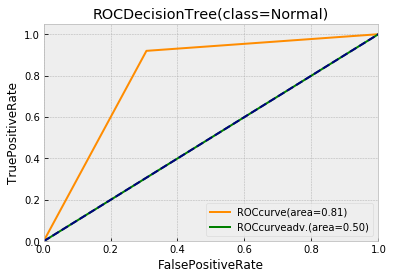

In [62]:
plt.figure()
lw=2
plt.plot(fpr_dt,tpr_dt,color='darkorange',
lw=lw,label='ROCcurve(area=%0.2f)'%roc_auc_dt)
plt.plot(fpr_dt_adv,tpr_dt_adv,color='green',lw=lw,label='ROCcurveadv.(area=%0.2f)'%roc_auc_dt_adv)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('FalsePositiveRate')
plt.ylabel('TruePositiveRate')
plt.title('ROCDecisionTree(class=Normal)')
plt.legend(loc="lower right")
plt.savefig('ROC_DT.png')


In [63]:
#Random Forest
rf=OneVsRestClassifier(RandomForestClassifier(n_estimators=200,random_state=42))
rf.fit(X_train_scaled,y_train)
y_pred=rf.predict(X_test_scaled)
fpr_rf,tpr_rf,_=roc_curve(y_test[:,0],y_pred[:,0])
roc_auc_rf=auc(fpr_rf,tpr_rf)
print("Accuracyscore:",accuracy_score(y_test,y_pred))
print("F1score:",f1_score(y_test,y_pred,average='micro'))
print("AUCscore:",roc_auc_rf)


Accuracyscore: 0.7396646557842441
F1score: 0.7549139216483665
AUCscore: 0.8075476855021121


In [64]:

y_pred_adv=rf.predict(X_adv)
fpr_rf_adv,tpr_rf_adv,_=roc_curve(y_test[:,0],y_pred_adv[:,0])
roc_auc_rf_adv=auc(fpr_rf_adv,tpr_rf_adv)
print("Accuracyscoreadversarial:",accuracy_score(y_test,y_pred_adv))
print("F1scoreadversarial:",f1_score(y_test,y_pred_adv,average='micro'))
print("AUCscoreadversarial:",roc_auc_rf_adv)


Accuracyscoreadversarial: 0.43075762952448543
F1scoreadversarial: 0.43075762952448543
AUCscoreadversarial: 0.5


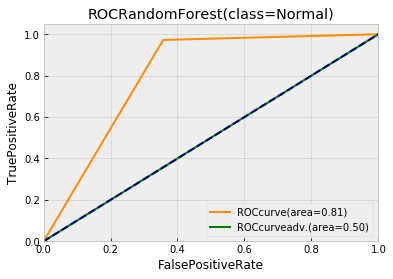

In [65]:
plt.figure()
lw=2
plt.plot(fpr_rf,tpr_rf,color='darkorange',
lw=lw,label='ROCcurve(area=%0.2f)'%roc_auc_rf)
plt.plot(fpr_rf_adv,tpr_rf_adv,color='green',
lw=lw,label='ROCcurveadv.(area=%0.2f)'%roc_auc_rf_adv)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('FalsePositiveRate')
plt.ylabel('TruePositiveRate')
plt.title('ROCRandomForest(class=Normal)')
plt.legend(loc="lower right")
plt.savefig('ROC_RF.png')

In [66]:
#SVM
sv=OneVsRestClassifier(LinearSVC(C=1.,random_state=42,loss='hinge'))
sv.fit(X_train_scaled,y_train)

y_pred=sv.predict(X_test_scaled)
fpr_sv,tpr_sv,_=roc_curve(y_test[:,0],y_pred[:,0])
roc_auc_sv=auc(fpr_sv,tpr_sv)
print("Accuracyscore:",accuracy_score(y_test,y_pred))

print("F1score:",f1_score(y_test,y_pred,average='micro'))
print("AUCscore:",roc_auc_sv)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracyscore: 0.7311036195883606
F1score: 0.7501488653154842
AUCscore: 0.7748643544079632


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [67]:
y_pred_adv=sv.predict(X_adv)
fpr_sv_adv,tpr_sv_adv,_=roc_curve(y_test[:,0],y_pred_adv[:,0])
roc_auc_sv_adv=auc(fpr_sv_adv,tpr_sv_adv)
print("Accuracyscoreadversarial",accuracy_score(y_test,y_pred_adv))
print("F1scoreadversarial:",f1_score(y_test,y_pred_adv,average='micro'))
print("AUCscoreadversarial:",roc_auc_sv_adv)

Accuracyscoreadversarial 0.43075762952448543
F1scoreadversarial: 0.43075762952448543
AUCscoreadversarial: 0.5


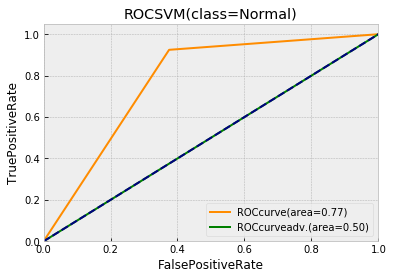

In [68]:
plt.figure()
lw=2
plt.plot(fpr_sv,tpr_sv,color='darkorange',
lw=lw,label='ROCcurve(area=%0.2f)'%roc_auc_sv)
plt.plot(fpr_sv_adv,tpr_sv_adv,color='green',
lw=lw,label='ROCcurveadv.(area=%0.2f)'%roc_auc_sv_adv)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('FalsePositiveRate')
plt.ylabel('TruePositiveRate')
plt.title('ROCSVM(class=Normal)')
plt.legend(loc="lower right")
plt.savefig('ROC_SVM.png')
